# Test Dual-Stream Time Series Forecasting Model

This notebook tests the iTransformer + Powerformer dual-stream architecture on weather data.

In [36]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from model import Model

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.9.0+cpu
CUDA available: False
Using device: cpu


## 1. Load and Explore Data

In [37]:
# Load data
df = pd.read_csv('./data/mpi_saale_2024.csv', parse_dates=['Date Time'])

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Dataset shape: (52703, 31)

Columns: ['Date Time', 'p (mbar)', 'T (degC)', 'rh (%)', 'sh (g/kg)', 'Tpot (K)', 'Tdew (degC)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'wd (deg)', 'rain (mm)', 'SWDR (W/m**2)', 'SDUR (s)', 'TRAD (degC)', 'Rn (W/m**2)', 'ST002 (degC)', 'ST004 (degC)', 'ST008 (degC)', 'ST016 (degC)', 'ST032 (degC)', 'ST064 (degC)', 'ST128 (degC)', 'SM008 (%)', 'SM016 (%)', 'SM032 (%)', 'SM064 (%)', 'SM128 (%)']


,Date Time,p (mbar),T (degC),rh (%),sh (g/kg),Tpot (K),Tdew (degC),VPmax (mbar),VPact (mbar),VPdef (mbar),...,ST008 (degC),ST016 (degC),ST032 (degC),ST064 (degC),ST128 (degC),SM008 (%),SM016 (%),SM032 (%),SM064 (%),SM128 (%)
0,01.01.2024 00:10:00,988.83,8.01,70.39,4.77,282.06,2.97,10.75,7.56,3.18,...,5.74,6.14,6.67,7.84,9.18,38.31,34.08,34.6,35.27,38.65
1,01.01.2024 00:20:00,988.69,8.02,69.84,4.74,282.09,2.87,10.75,7.51,3.24,...,5.74,6.14,6.67,7.84,9.18,38.29,34.08,34.6,35.27,38.65
2,01.01.2024 00:30:00,988.66,8.19,68.28,4.69,282.26,2.71,10.88,7.43,3.45,...,5.74,6.14,6.67,7.84,9.18,38.23,34.07,34.6,35.27,38.65
3,01.01.2024 00:40:00,988.72,8.23,67.87,4.67,282.29,2.67,10.91,7.40,3.50,...,5.74,6.14,6.67,7.84,9.18,37.98,34.07,34.6,35.26,38.65
4,01.01.2024 00:50:00,988.81,8.14,67.82,4.64,282.20,2.57,10.84,7.35,3.49,...,5.73,6.14,6.67,7.84,9.18,37.63,34.07,34.6,35.26,38.65


In [38]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum().sort_values(ascending=False).head(10))
print(f"Total Nan: {df.isnull().sum().sum()}")

# Drop Date Time column and get numeric features
data = df.drop(columns=['Date Time']).values
print(f"Number of variates: {data.shape[1]}")
print(f"Number of timesteps: {data.shape[0]}")

Missing values:
Date Time       0
p (mbar)        0
T (degC)        0
rh (%)          0
sh (g/kg)       0
Tpot (K)        0
Tdew (degC)     0
VPmax (mbar)    0
VPact (mbar)    0
VPdef (mbar)    0
dtype: int64
Total Nan: 0
Number of variates: 30
Number of timesteps: 52703


## 2. Prepare Dataset

In [39]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, lookback=48, forecast=12):
        """
        Args:
            data: numpy array of shape [timesteps, num_variates]
            lookback: number of past timesteps to use
            forecast: number of future timesteps to predict
        """
        self.data = torch.FloatTensor(data)
        self.lookback = lookback
        self.forecast = forecast
        
    def __len__(self):
        return len(self.data) - self.lookback - self.forecast + 1
    
    def __getitem__(self, idx):
        # Input: [lookback, num_variates]
        x = self.data[idx:idx + self.lookback]
        # Target: [forecast, num_variates]
        y = self.data[idx + self.lookback:idx + self.lookback + self.forecast]
        return x, y

# Settings
lookback_steps = 96   # Use 96 timesteps (16 hours at 10-min intervals)
forecast_steps = 24   # Predict 24 timesteps (4 hours ahead)

print(f"Lookback window: {lookback_steps} steps")
print(f"Forecast window: {forecast_steps} steps")

Lookback window: 96 steps
Forecast window: 24 steps


In [40]:
# Normalize data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

# Train/test split (80/20)
train_size = int(0.8 * len(data_normalized))
train_data = data_normalized[:train_size]
test_data = data_normalized[train_size:]

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Create datasets
train_dataset = TimeSeriesDataset(train_data, lookback_steps, forecast_steps)
test_dataset = TimeSeriesDataset(test_data, lookback_steps, forecast_steps)

print(f"\nTrain samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check one batch
x_sample, y_sample = next(iter(train_loader))
print(f"\nSample batch:")
print(f"  Input shape: {x_sample.shape}  (batch, lookback, variates)")
print(f"  Target shape: {y_sample.shape}  (batch, forecast, variates)")

Train data shape: (42162, 30)
Test data shape: (10541, 30)

Train samples: 42043
Test samples: 10422

Sample batch:
  Input shape: torch.Size([32, 96, 30])  (batch, lookback, variates)
  Target shape: torch.Size([32, 24, 30])  (batch, forecast, variates)


## 3. Initialize Model

In [41]:
# Model configuration
num_variates = data.shape[1]  # 30 weather variables

model = Model(
    num_variates=num_variates,
    lookback_steps=lookback_steps,
    forecast_steps=forecast_steps,
    
    d_model=128,  # Embedding dimension (same for both streams)
    
    # Stream 1: iTransformer
    n_heads_s1=2,
    n_layers_s1=1,
    d_ff_s1=128,
    dropout_s1=0.1,
    
    # Stream 2: Powerformer
    patch_len=2,
    stride=8,
    n_heads_s2=2,
    n_layers_s2=1,
    d_ff_s2=128,
    dropout_s2=0.1,
    attn_decay_scale=0.25,
    
    # Fusion
    n_heads_fusion=2,
)

model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model initialized!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model initialized!
Total parameters: 350,104
Trainable parameters: 350,104


## 4. Test Forward Pass

Input shape: torch.Size([32, 96, 30])
Output shape: torch.Size([32, 24, 30])
Initial MSE (untrained): 0.4065


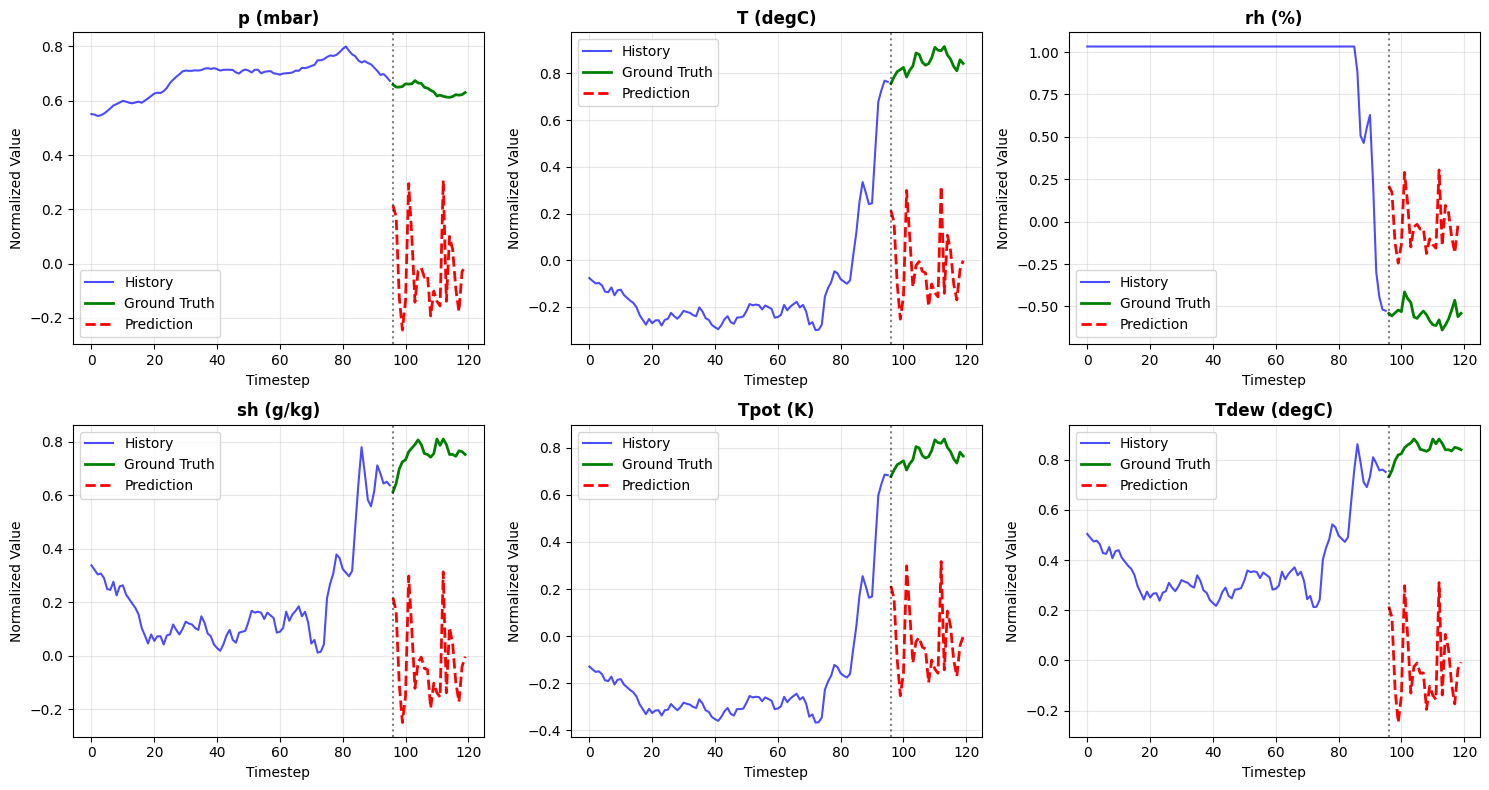

In [42]:
import matplotlib.pyplot as plt

# Test forward pass with one batch
model.eval()
with torch.no_grad():
    x_test, y_test = next(iter(test_loader))
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    
    print(f"Input shape: {x_test.shape}")
    
    # Forward pass
    predictions = model(x_test)
    
    print(f"Output shape: {predictions.shape}")
    
    # Calculate MSE
    mse = nn.MSELoss()(predictions, y_test)
    print(f"Initial MSE (untrained): {mse.item():.4f}")
    
    # ===== SIMPLE PANDAS VISUALIZATION =====
    # Get first example and move to CPU
    x_sample = x_test[0].cpu().numpy()
    y_sample = y_test[0].cpu().numpy()
    pred_sample = predictions[0].cpu().numpy()
    
    # Get column names (exclude 'Date Time')
    variate_names = df.columns[1:].tolist()
    
    # Create DataFrames
    df_history = pd.DataFrame(x_sample, columns=variate_names)
    df_history['type'] = 'history'
    df_history['timestep'] = range(len(df_history))
    
    df_truth = pd.DataFrame(y_sample, columns=variate_names)
    df_truth['type'] = 'ground_truth'
    df_truth['timestep'] = range(lookback_steps, lookback_steps + len(df_truth))
    
    df_pred = pd.DataFrame(pred_sample, columns=variate_names)
    df_pred['type'] = 'prediction'
    df_pred['timestep'] = range(lookback_steps, lookback_steps + len(df_pred))
    
    # Plot first 6 variates
    variates_to_plot = variate_names[:6]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for i, var_name in enumerate(variates_to_plot):
        ax = axes[i]
        
        # Plot history
        df_history.plot(x='timestep', y=var_name, ax=ax, label='History', 
                       color='blue', alpha=0.7, legend=False)
        
        # Plot ground truth
        df_truth.plot(x='timestep', y=var_name, ax=ax, label='Ground Truth', 
                     color='green', linewidth=2, legend=False)
        
        # Plot predictions
        df_pred.plot(x='timestep', y=var_name, ax=ax, label='Prediction', 
                    color='red', linestyle='--', linewidth=2, legend=False)
        
        ax.axvline(x=lookback_steps, color='black', linestyle=':', alpha=0.5)
        ax.set_title(var_name, fontweight='bold')
        ax.set_xlabel('Timestep')
        ax.set_ylabel('Normalized Value')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 5. Training Loop

In [43]:
from tqdm import tqdm

# Training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

# Training history
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    
    # Progress bar for training batches
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    for x_batch, y_batch in pbar:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        predictions = model(x_batch)
        loss = criterion(predictions, y_batch)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # Update progress bar
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Evaluation
    model.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        pbar_test = tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Test]')
        for x_batch, y_batch in pbar_test:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            predictions = model(x_batch)
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()
            
            pbar_test.set_postfix({'loss': f'{loss.item():.4f}'})
    
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}\n")

Epoch 1/5 [Train]:   0%|          | 0/1314 [00:00<?, ?it/s]

Epoch 1/5 [Test]: 100%|██████████| 326/326 [00:10<00:00, 31.32it/s, loss=0.1292]


Epoch [1/5] - Train Loss: 0.1912, Test Loss: 0.1053



Epoch 2/5 [Train]:  45%|████▌     | 597/1314 [02:35<03:07,  3.83it/s, loss=0.1403]


KeyboardInterrupt: 

## 6. Training Progress

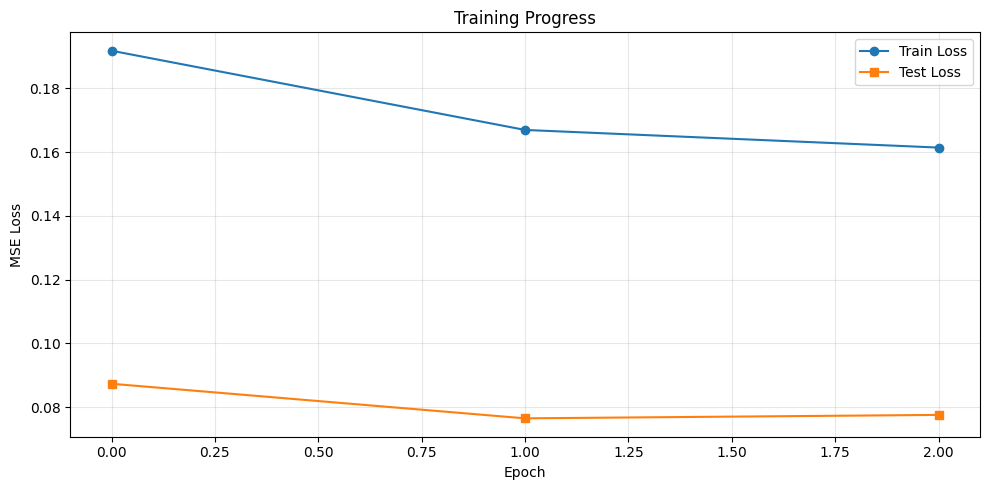

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(test_losses, label='Test Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Visualize Predictions

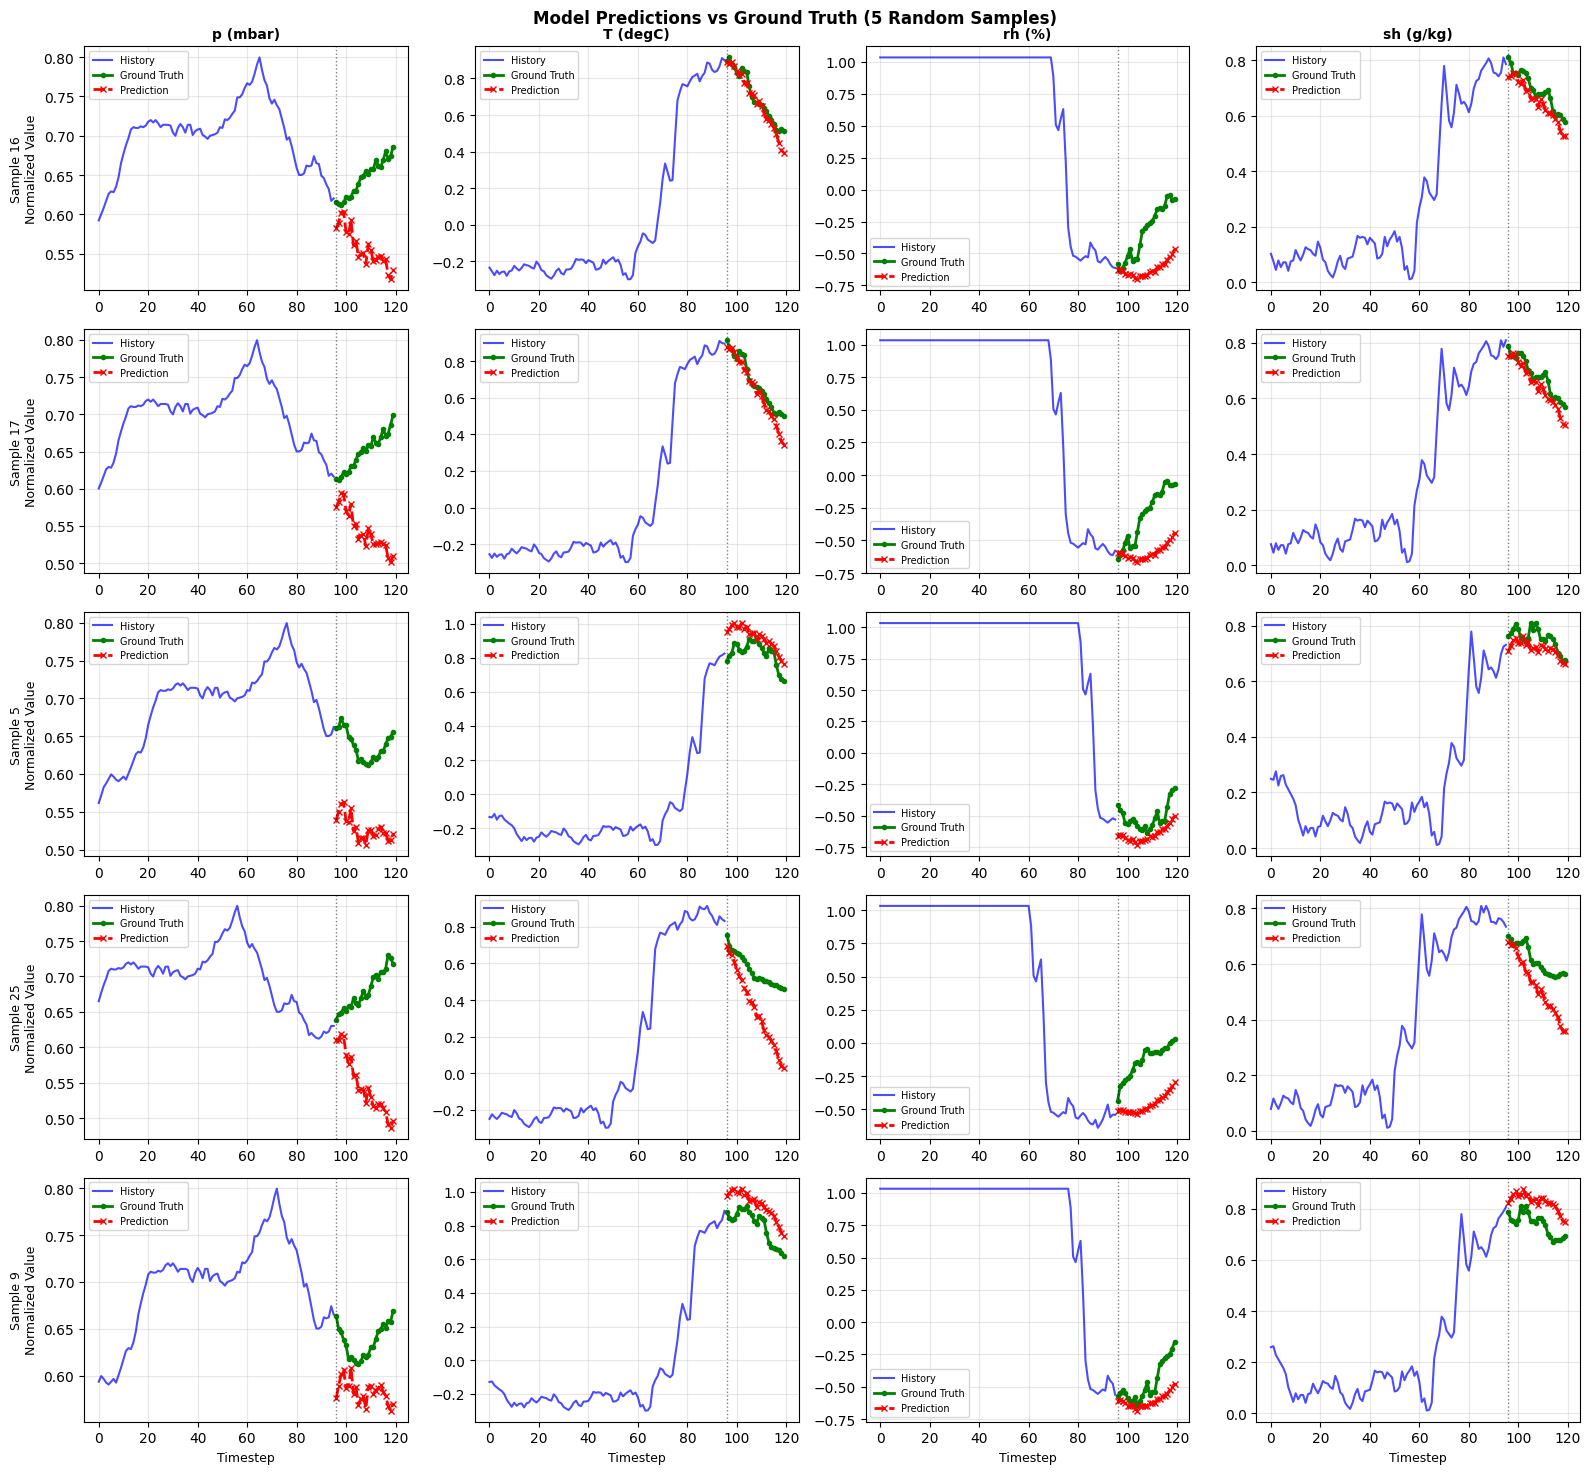

In [ ]:
NUM_SAMPLES_TO_CHECK = 5  

model.eval()
with torch.no_grad():
    # Get a test batch
    x_test, y_test = next(iter(test_loader))
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    predictions = model(x_test)
    
    # Randomly sample from the batch
    batch_size = x_test.shape[0]
    num_samples = min(NUM_SAMPLES_TO_CHECK, batch_size)
    
    # Randomly select samples
    sample_indices = np.random.choice(batch_size, num_samples, replace=False)

    # Get column names (exclude 'Date Time')
    variate_names = df.columns[1:].tolist()
    
    # Create subplot grid
    rows = num_samples
    cols = min(4, len(variate_names))  # Show up to 4 variates per sample
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    if cols == 1:
        axes = axes.reshape(-1, 1)
    
    for i, sample_idx in enumerate(sample_indices):
        # Get data for this sample
        x_sample = x_test[sample_idx].cpu().numpy()
        y_sample = y_test[sample_idx].cpu().numpy()
        pred_sample = predictions[sample_idx].cpu().numpy()
        
        # Plot each variate
        for j, var_name in enumerate(variate_names[:cols]):
            ax = axes[i, j]
            
            # Plot history (lookback)
            history_timesteps = range(len(x_sample))
            ax.plot(history_timesteps, x_sample[:, j], 
                   label='History', color='blue', alpha=0.7, linewidth=1.5)
            
            # Plot ground truth (forecast)
            forecast_timesteps = range(len(x_sample), len(x_sample) + len(y_sample))
            ax.plot(forecast_timesteps, y_sample[:, j], 
                   label='Ground Truth', color='green', linewidth=2, marker='o', markersize=3)
            
            # Plot predictions (forecast)
            ax.plot(forecast_timesteps, pred_sample[:, j], 
                   label='Prediction', color='red', linestyle='--', linewidth=2, marker='x', markersize=4)
            
            # Add vertical line separating history and forecast
            ax.axvline(x=len(x_sample), color='black', linestyle=':', alpha=0.5, linewidth=1)
            
            # Set titles and labels
            if i == 0:
                ax.set_title(f'{var_name}', fontweight='bold', fontsize=10)
            if j == 0:
                ax.set_ylabel(f'Sample {sample_idx}\nNormalized Value', fontsize=9)
            if i == rows - 1:
                ax.set_xlabel('Timestep', fontsize=9)
            
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=7)
    
    plt.suptitle(f'Model Predictions vs Ground Truth ({num_samples} Random Samples)', fontweight='bold', fontsize=12)
    plt.tight_layout()
    plt.show()